# Representing Object Association with Vector Similarity

Steven Agland - [sagland@gmail.com](mailto:sagland@gmail.com)

## Abstract

In many data applications it is common to track a large number of objects with a large number of connections between them. In such situations in can be useful to infer possible second-degree, or higher, associations between a pair of objects. These associations maybe implicit in the common connections from the pair to other objects. Examples of such applications include [recommender systems](https://en.wikipedia.org/wiki/Recommender_system) or [Information Retrieval](https://en.wikipedia.org/wiki/Information_retrieval).

Finding and ranking such indirect associations efficiently is a difficult computation problem. In this notebook I explore the idea of using fixed-length vectors assigned to each object to encode associations probabilistically. The strength of association between a pair of objects is represented by the similarity of their vectors and can be meaningful even if no explicit association were provided in the input data. There need be no meaning inherent in the elements of the vectors themselves, which can be seeded with random values. But an iterative refinement process can adjust the values such that their similarity to one another reflects the association of their corresponding objects. This provides a fast means of computing the likelihood of an association between any two objects for which no prior knowledge exists.

I'll explore the tradeoffs involved in the selection of vector spaces, similarity measures, and algorithms for refining the vectors. In particular I'll consider two classes of vector spaces: hyperspherical surfaces, and bit strings.

## Introduction
### Background - Mine

For context and full disclosure, I do not have a strong academic background in information retrieval, machine learning, or linear algebra for that matter. In each of these I am more than a beginner, but not much more. I studied undegraduate-level Computer Science and have spent the better part of the 15 years since working in the computer graphics industry - with a particular focus on offline rendering and light transport simulation for film. As such I am comfortable thinking about spatial problems and probablistic solutions.

This investigation grew out of a now-shelved personal upskilling project to develop a social website. An interesting mathematical puzzle emerged and soon eclipsed my interest in the website itself, and I've decided now to try to lay it out the investigation formally.

### Background - The Problem

Consider a recommendation system to which you can provide a set of your personal preferences. These may related to food, music, hobbies, political persuasions, life values and so on. Given these, and the knowledge of the preferences of thousands of other users, the system might predict your preference areas for which you've provided no information, or for which you do not yet have a preference. For example, the system might predict which of three countries you would most enjoy visiting, even though you have yet to visit any of them. This prediction would be informed by the input from other users with preferences similar to yours.

How could the system make such a prediction? What if you expressed no preferences in common with any other user who had expressed a preference for the countries in question? Could an indirect association be found without an direct association between those concepts being known? In this example, perhaps a taste for spicy food correlates with tourism tropical countries. Could that association be determined automatically as a probability-like score?

This simple preference prediction system serves as an example application to which I will refer throughout the rest of this notebook. It should be clear how such an approach could be applied to other systems, such as product recommendation engines in online stores, automated news feeds, targeted advertising, detecting correlations in complex data sets, and so on.

The process described here is one way to solve this problem, and many other solutions already exist. It may well be that the concepts explored herein have been thoroughly mapped elsewhere in terms with which I'm unfamiliar, and in research I haven't been able to find. Pointers to existing papers are welcome, and I hope that the ideas presented here could be of value to readers and researchers interested in such topics.

### Approach

I will explore the idea of mapping each object in a data set to a vector in a space in such a way that vector similarity implies object association. The hypothesis is that by using a set of known true associations to construct this map, it will yield a new set hitherto unknown associations, each with a probability measure. If proven practical, this would be a form of machine learning.

I'll investigate two classes of vector spaces: unit hyperspherical surfaces in $\mathbb{R}^n$, and bit strings in $\{0, 1\}$.

... WIP ...

## Mapping Associations to Spatial Proximity

An intuitive way to solve the association problem described above is to imagine objects as points in space. Objects that we know are associated in some way we would place closer together. In our example preference-prediction system, we might have a point representing a user - Alice - and a point representing a preferential concept - say, classical music. If Alice expresses a preference to that genre, we move her point closer to the genre's point. We might also move the genre closer to Alice, thus indirectly moving it closer to Alice's other preferences. Objects which we know have a negative association (such as a *dislike* in the preference-predicton example) we move away from each other. Strongly weighted associations would require moves over a longer a distance. We might think of associations mapping to attraction or repulsion in a dynamic physical system.

If many lovers of classical music disproportionately favour red wine over white, we would expect, after all known associations are taken into account when laying out our concepts in space, that the *red wine* point would lie relatively close to the *classical music* point compared to *white wine*.

I will explore some of the considerations inherent in designing such a system.

### The Choice of Space

Given this description, an obvious starting point is to imagine these points floating in 2- or 3-dimensional Euclidean space. This maps to our intuitions of dynamic systems. Entity-relationship graphs are often represented as nodes laid out on a 2D plane. Ideas of attraction and repulsion conjure images of spinning 3-dimensional solar system models.

But when one tries to imagine how such a system of might relax into a stable state with object positions that satifying our condition that proximity represents association well, a problem quickly becomes apparent: such spaces are unbounded. What would be the spatial limits to our cloud of points? The numeric distance values become problematic. How do we seed starting positions? Is a euclidian distance of 1 unit considered near or far, strongly associated, neutral, negatively associated? Do we need to have some idea of the mean distance between points?

It gets messier still when we consider the behavior of points with many negatively associations. Do they retreat indefinitely from the rest of the cloud?

#### The Trivial Cases

To bring the problem back under control, let's consider some of the simplest cases. The most simple system (beside an empty system) has a single object. It naturally has no associations with any other object. Since the purpose of the system is to represent associations using spatial proximity, there is nothing for this system to represent. The object can be given any position, it won't matter.

More interesting are cases involving a data set of only two objects. In one case the objects have a positive association, in a second case they have no association, and in the third case they have a negative association. How can we arrange our points to best represent these associations?

Firstly, if the only information we have about the two objects is that they are associated, then the only justifiable value for their distance is 0. Their positions are irrelevant, other than that they are the same. This fairly represents our dataset: the objects have 100% correleation and there are no confounding factors, like a third object to which one is associated and the other not.

Secondly, if the two objects have no association, then any distance is justifiable, since we know nothing about the the relationship between the two objects, and as such any position is also justifiable.

Finally, if the two objects have a negative association, then the distance should be maximal. Like the positive-association case, there are no confounding factors, their disassociation is absolute and the only information the system is required to represent.

Is it is this last case that most clearly illustrates the problem with unbounded spaces: for any point in the space, there needs to be another point maximally distance from it.

#### Hyperspherical Spaces

Which bounded spaces are most appropriate? Simply defining a box of legal values would lead to inelegant clumping of particularly repulsive objects in edges and corners. Modular wrap-around spaces begin to feel more plausible. But a more elegant solution turns out to be the non-Euclidean surface of a sphere, or more generally, a hypersphere.

Using a spherical surface solves several problems. Firstly, for every point there is a corresponding *opposite* point. In fact, representing a negative assocation to a point can be implemented simply as a positive association to the point 180 degrees away from it.

The boundedness of a spherical surface also removes the problem of units and scale. Distance can be measured as an angle in radians measured between the pont vectors from the origin. A distance (angle) of 0 represents complete association and a distance of $\pi$ (or $180^o$) represents complete disassociation.

If $\mathbf{p}$ and $\mathbf{q}$ are two vectors representing points in $\mathbb{R}^n$ on the unit $(n-1)$-sphere ($||\mathbf{p}|| = ||\mathbf{q}|| = 1$), then their distance angle $\mathrm{D}$ can be measured as the arc cosine of their dot product:

$$D(\mathbf{p},\mathbf{q}) = \arccos(\mathbf{p}\cdot\mathbf{q})$$

I will be using hyperspherical surfaces as the spatial model in the next few sections, and in particular I'll use the familiar *2-sphere* in 3D space for illustrations. See *Fig. 1*.

In [307]:
# Let's spin up our python workspace.
%matplotlib inline
from math import sqrt, acos, pi, sin, cos
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

In [308]:
# A convenience function for plotting illustrations on 2-sphere
# in 3D space.
def drawsphere(ax):
    ax.grid(False)
    ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.set_xlim3d(-1,1)
    ax.set_ylim3d(-1,1)
    ax.set_zlim3d(-1,1)
    u, v = np.linspace(0, 2 * np.pi, 32), np.linspace(0, np.pi, 16)
    ax.plot_wireframe(np.outer(np.cos(u), np.sin(v)), np.outer(np.sin(u), np.sin(v)),
                      np.outer(np.ones(np.size(u)), np.cos(v)),
                      color='k', linestyle=':', alpha=0.3)
    # Draw the origin
    ax.plot([-.1,.1],[0,0],[0,0], color='k', alpha=0.2)
    ax.plot([0,0],[-.1,.1],[0,0], color='k', alpha=0.2)
    ax.plot([0,0],[0,0],[-.1,.1], color='k', alpha=0.2)

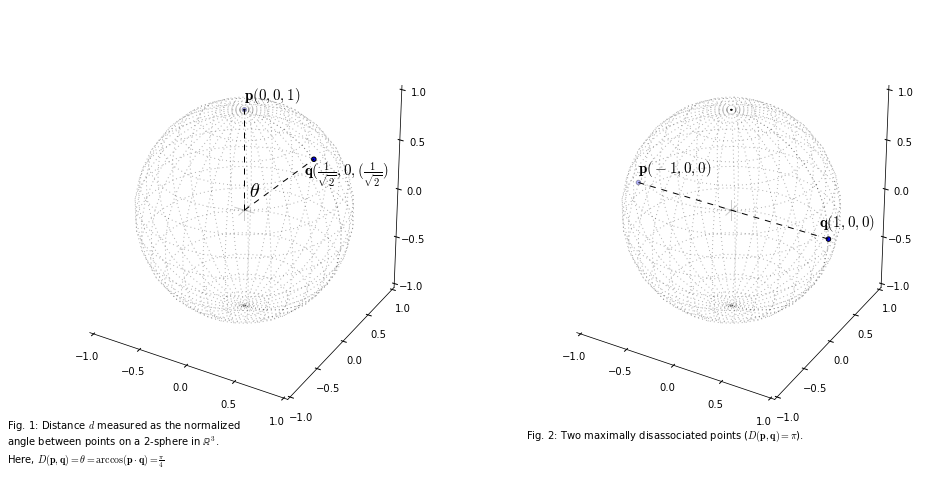

In [332]:
fig = plt.figure(figsize=(16,7.5))
ax1= fig.add_subplot(121, projection='3d')
drawsphere(ax1)
ir2 = 2.0**-0.5
ax1.scatter([0,ir2], [0,0], [1,ir2])
ax1.plot([0,0], [0,0], [0,1], c='k', linestyle='--')
ax1.plot([0,ir2], [0,0], [0,ir2], c='k', linestyle='--')
ax1.text(0.05, 0, 0.15, "$\\theta$", fontsize=20)
ax1.text(0,0,1.1,"$\\mathbf{p} (0,0,1)$", fontsize=15)
ax1.text(ir2-.1,0,ir2-.2,'$\\mathbf{q} (\\frac{1}{\\sqrt{2}},0,(\\frac{1}{\\sqrt{2}})$', fontsize=15)
fig.text(0.1, 0.05, 'Fig. 1: Distance $d$ measured as the normalized\n'
        'angle between points on a 2-sphere in $\mathbb{R}^3$.\n'
        'Here, $D(\\mathbf{p},\\mathbf{q}) = {\\theta} = \\arccos(\\mathbf{p}\\cdot\\mathbf{q}) = \\frac{\\pi}{4}$')

# Illustrate polar opposite points (maximal negative association)
ax2 = fig.add_subplot(122, projection='3d')
drawsphere(ax2)
ax2.scatter([-1,1], [0,0], [0,0])
ax2.plot([-1,1], [0,0], [0,0], c='k', linestyle='--')
ax2.text(-1,0,0.1,"$\\mathbf{p} (-1,0,0)$", fontsize=15)
ax2.text( 1-0.1,0,0.1,"$\\mathbf{q} (1,0,0)$", fontsize=15)
fig.text(0.55, 0.1, 'Fig. 2: Two maximally disassociated points ($D(\\mathbf{p},\\mathbf{q}) = \\pi$).')
plt.show()

So we now have satisfying answers to our trivial cases: two purely associated points are co-located, two purely negatively associated points are at polar opposites *(Fig. 2)*, and two unassociated points can be at any two arbitrary locations.

This last rule seems the least satisfying. Should unassociated points be strictly at a neutral $D = \frac{\pi}{2}$? No, because this would imply that we have some knowledge about their association. For example, Alice might rate a film 5 stars, out of a range of 0 - 10. This knowledge of a neutral association would require us to place Alice's point at a distance of $\frac{\pi}{2}$ from the film's - all else being equal. But this will be a probabilistic system: the less we know about an association, the more *unpredictable* the corresponding distance should be.

### The Choice of Dimensionality

The notion of the inherent probabilistic nature of the system suggests that randomness will need to play some role. It also raises a problem: when we measure the distance between two points, how do we know whether it represents a well-defined association, as opposed to simple chance?

The magnitude of this problem depends on the distribution of possible distances, given a uniform distribution of points in the space. If a measured distance is statistically unlikely we would feel more confident of its significance. And as we will see, that distribution depends heavily of the dimensionality of the vector space.

A high-dimensional space yields more of these statistically significant measurements from a given set of associations. Such spaces require larger vectors, which naturally contain more information (assuming a constant element size in bits). It follows intuitively that the more information stored in the system, the more insight might be gleaned from it.

This tradeoff between keeping vector sizes small, and maximizing effectiveness of the system will be one of the main themes of this investigation.

#### The Probability Distribution of Hyperspherical Distances

Let's explore the distribution of distances given a uniform distribution of points on the surface of a hypersphere. The problem can be simplified by taking a single point and considering the distribution of distances to other uniformly distributed points. This distribution will be the same for any point.

I'll begin with the question: given a two points $\mathbf{p}$ and $\mathbf{q}$, what is the probability, given a third point $\mathbf{r}$ uniformly sampled on the surface, that $D(\mathbf{p},\mathbf{r}) < D(\mathbf{p},\mathbf{q})$? Such a probability - or rather, its opposite - will be useful as a similarity measure.

This probability value is equivalent to proportion of the area of the *hyperspherical cap* described by the angle between points $\mathbf{p}$ and $\mathbf{q}$ to the area of the hypersphere as a whole (see *Fig 3*). This is because the cap contains all points closer to $\mathbf{p}$ than $\mathbf{q}$. The smaller the cap, the fewer closer points, and the smaller the probability that a uniformly sampled point would be at a shorter distance. Conversely, the higher the probability a uniformly sampled point would be at a longer distance.

In [310]:
def hs_sample(m, n):
    '''Returns m vectors uniformly sampled over the surface
    of a hypersphere in n-d space. Uses Marsaglia's algorithm.'''
    vs = np.random.standard_normal((m, n))
    return vs / np.linalg.norm(vs, axis=1)[:,None]

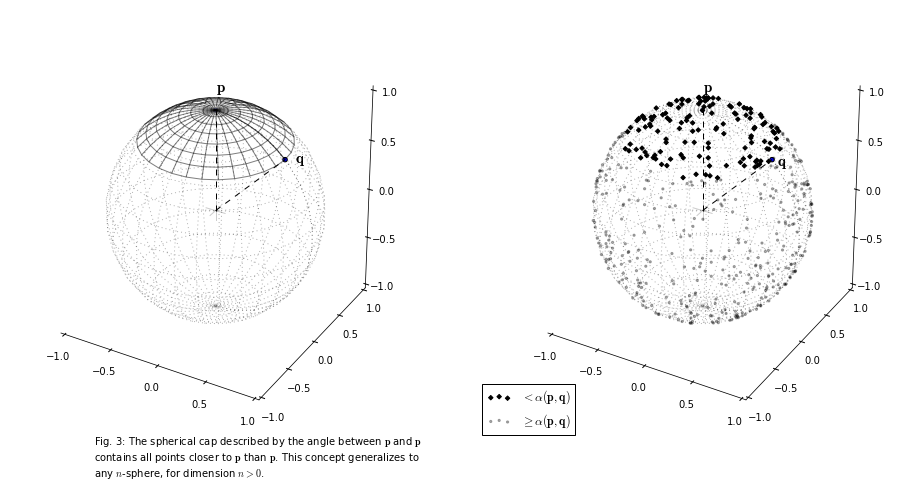

In [327]:
fig = plt.figure(figsize=(16,7.5))
ax1= fig.add_subplot(121, projection='3d')
drawsphere(ax1)
# Draw a spherical cap at an angle of pi/4
u, v = np.linspace(0, 2 * np.pi, 32), np.linspace(0, np.pi/4, 8)
ax1.plot_wireframe(np.outer(np.cos(u), np.sin(v)), np.outer(np.sin(u), np.sin(v)),
                   np.outer(np.ones(np.size(u)), np.cos(v)),
                   color='k', linestyle='-', alpha=0.5)
ir2 = 2.0**-0.5
ax1.scatter([0,ir2], [0,0], [1,ir2])
ax1.plot([0,0], [0,0], [0,1], color='k', linestyle='--')
ax1.plot([0,ir2], [0,0], [0,ir2], color='k', linestyle='--')
ax1.text(0,0,1.175,"$\\mathbf{p}$", fontsize=15)
ax1.text(ir2+.1,0,ir2,'$\\mathbf{q}$', fontsize=15)

ax2= fig.add_subplot(122, projection='3d')
drawsphere(ax2)
ps = hs_sample(1024, 3) # Sample some points
# Cull points on the backface of the sphere
t, p = np.radians(90 - ax2.elev), np.radians(ax2.azim)
atcam = np.array([sin(t) * cos(p), sin(t) * sin(p), cos(t)])
ps = ps[(ps * atcam).sum(1) > 0] # Dot product with vec pointing at camera
# Seperate out points inside or outside the cap
ips = ps[ps[:,2] > ir2]
ops = ps[ps[:,2] <= ir2]
ax2.scatter([0,ir2], [0,0], [1,ir2])
ax2.plot([0,0], [0,0], [0,1], color='k', linestyle='--')
ax2.plot([0,ir2], [0,0], [0,ir2], color='k', linestyle='--')
ax2.text(0,0,1.175,"$\\mathbf{p}$", fontsize=15)
ax2.text(ir2+.05,0,ir2-0.05,'$\\mathbf{q}$', fontsize=15)
ax2.scatter(ips[:,0], ips[:,1], ips[:,2],
            c='k', s=10, alpha=1.0, marker='D', label='$< \\alpha(\\mathbf{p},\\mathbf{q})$')
ax2.scatter(ops[:,0], ops[:,1], ops[:,2],
            c='k', s=5, alpha=0.3, marker='o', label='$\\geq \\alpha(\\mathbf{p},\\mathbf{q})$')
ax2.scatter(x, y, z)
plt.legend(bbox_to_anchor=(0.2, 0.1), borderaxespad=0.0)
fig.text(0.2, 0.03, 'Fig. 3: The spherical cap described by the angle between $\\mathbf{p}$ and $\\mathbf{p}$\n'
                   'contains all points closer to $\\mathbf{p}$ than $\\mathbf{p}$. This concept generalizes to\n'
                   'any $n$-sphere, for dimension $n > 0$.')

plt.show()    

[Li (2011)](http://scialert.net/fulltext/?doi=ajms.2011.66.70&org=11) provides a concise formula for calculating the area of a hyperspherical cap with an angle $0 < \theta < \frac{\pi}{2}$.

$$A_n^{cap}(r, \theta) = \frac{1}{2} A_n(r) I_{\sin^2\theta}\left(\frac{n-1}{2},\frac{1}{2}\right)$$

$I$ is the *regularized incomplete beta function*. $A_n(r)$ is the area of a hypersphere of radius $r$ in $\mathbb{R}^n$, which we can factor out since we need only compute the proportion of the cap's area relative to the total area. We'll call this proportional value $A_n^{cap\prime}$

$$A_n^{cap'}(\theta) = \frac{A_n^{cap}(r, \theta)}{A_n(r)} = \frac{1}{2}I_{\sin^2\theta}\left(\frac{n-1}{2},\frac{1}{2}\right)$$

In [312]:
from scipy.special import betainc
eps = np.finfo(float).eps
def hyperspherical_cap_proportion(angles, n):
    '''
    Calculates the proportion of the surface of a hypersphere covered
    by a 'hyperspherical cap' spanned by a certain angle.
    angles: array of angles in radians
    n: dimensions of the space, i.e., 3 for a 2-sphere
    From:
    S. Li , 2011. Concise Formulas for the Area and Volume of a
    Hyperspherical Cap. Asian Journal of Mathematics & Statistics, 4: 66-70.'''
    # Make sure we're measuring the smaller cap
    bigcap = angles > np.pi / 2
    sangles = angles * ~bigcap + (np.pi - angles) * bigcap
    result = betainc((n - 1) * 0.5, 0.5, np.sin(sangles)**2) / 2
    # Invert the results for the bigcaps
    result = result * ~bigcap + (1.0 - result) * bigcap
    return result

Given any two points on a hypersphere surface, we can now calculate the probability that will be uniformly sampled point would be closer. A low probability near $0$ indicates a high degree of association, while a probability near $1$ indicates a high degree of negative association.

This *hyperspherical cap proportion* corresponding to an angle can be seen as the *cumulative distribution function* (CDF) for distances between pairs of uniformly sampled points on the surfaces of hyperspheres. It follows that its <a href="http://www.wolframalpha.com/input/?i=derivative+of+BetaRegularized%5Bsin(x)%5E2,+(n-1)%2F2,+1%2F2%5D+%2F+2">derivative</a> is the *probability density function* (PDF) for these distances.

$$
\frac{d}{d \theta}A_n^{cap'}(\theta)
=
\frac{d}{d \theta}\left(\frac{1}{2}I_{\sin^2\theta}\left(\frac{n-1}{2},\frac{1}{2}\right)\right)
=
\frac
{\sin(\theta) \cos(\theta) \sin^2(\theta)^{\frac{n-1}{2} - 1}}
{\mathrm{B}\left(\frac{n-1}{2},\frac{1}{2}\right)\sqrt{1-\sin^2(\theta)}}
$$

$\mathrm{B}$ is the beta function.

In [313]:
from scipy.special import beta
def hyperspherical_angle_pdf(angles, n):
    '''
    Calculates the probability density function over the angles between
    pairs of uniformly sampled points on a hypersphere. This is the
    derivative of the hyperspherical cap proportion described by the angle.
    angles: array of angles in radians
    n: dimensions of the space, i.e., 3 for a 2-sphere
    From: http://www.wolframalpha.com/input/?i=derivative+of+BetaRegularized%5Bsin(x)%5E2,+(n-1)%2F2,+1%2F2%5D+%2F+2
          (sin(x) cos(x) sin^2(x)^((n-1)/2-1))/(beta((n-1)/2, 1/2) sqrt(1-sin^2(x)))
    '''
    # Make sure we're measuring the smaller cap
    x = np.clip(np.pi/2 - np.abs(np.pi/2 - angles), eps, np.pi / 2)
    sx, cx = np.sin(x), np.cos(x)
    hsn = (n - 1) / 2.0
    return ((sx * cx * ((sx**2)**(hsn - 1))) / (beta(hsn, 0.5) * np.sqrt(1 - sx**2)))

*Fig. 4* compares the probability curves obtained over the range of possible distances ($0 - \pi$) for a selection of dimensionalities. From it we can conclude that given two random points on a 2D circle, or 3D sphere, there is a fair chance that they'll be closer than a distance of $\frac{\pi}{4}$ (or $< 45^o$). But on a 12D hypersphere, the chance is extremely low.

*Fig. 5* The distribution of distances make clearer the effect that higher dimensions have. Distances are much more likely to be clustered around $\frac{\pi}{2}$. That is, as dimensionality increases, points tend to be at near-orthogonal angles to eachother. Distances around $0$ or $\pi$ are increasingly unlikely to happen by chance, which for our purposes means they can be interpreted as significant.

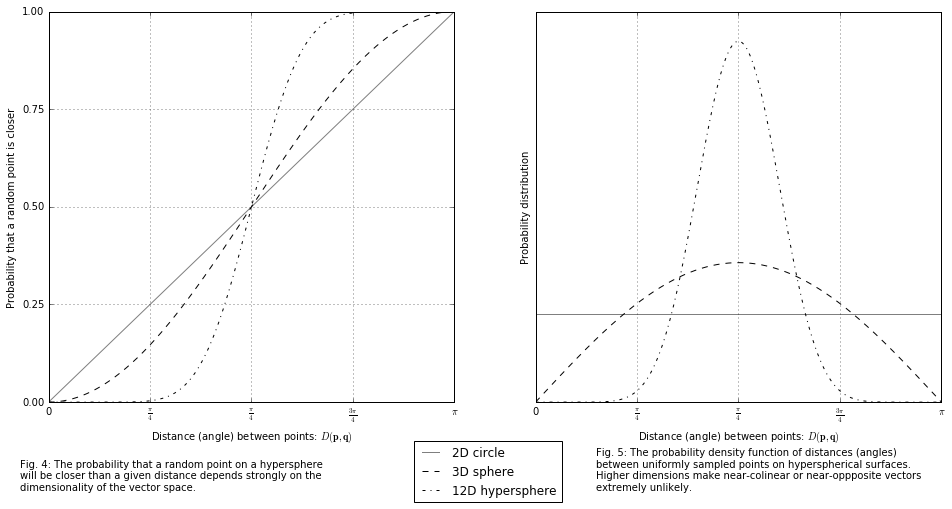

In [333]:
s = 512
dd = np.pi / (s - 1)
a = np.linspace(0.0, np.pi, s)

# Compute the CDFs of distances over angle.
cdf2 = hyperspherical_cap_proportion(a, 2)
cdf3 = hyperspherical_cap_proportion(a, 3)
cdf12 = hyperspherical_cap_proportion(a, 12)

# Compute the PDFs as a derivative
pdf2 = hyperspherical_angle_pdf(a, 2)
pdf3 = hyperspherical_angle_pdf(a, 3)
pdf12 = hyperspherical_angle_pdf(a, 12)

# Normalize PDFs
pdf2 /= (pdf2 * dd).sum()
pdf3 /= (pdf3 * dd).sum()
pdf12 /= (pdf12 * dd).sum()


fig = plt.figure(figsize=(16,7))
# Plot the CDFs
ax1 = fig.add_subplot(121)
ax1.plot(a, cdf2, c='k', linestyle='-', alpha=0.5, label='2D circle')
ax1.plot(a, cdf3, c='k', linestyle='--', label='3D sphere')
ax1.plot(a, cdf12, c='k', linestyle='-.', label='12D hypersphere')
ax1.grid()
ax1.set_xticks([0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi])
ax1.set_xticklabels(['0', '$\\frac{\\pi}{4}$','$\\frac{\\pi}{4}$','$\\frac{3\\pi}{4}$','$\\pi$'])
ax1.set_xlim((0, np.pi))
ax1.set_xlabel('Distance (angle) between points: $D(\\mathbf{p},\\mathbf{q})$')
ax1.set_yticks([x/4. for x in range(5)])
ax1.set_ylabel('Probability that a random point is closer')
fig.text(0.1,-0.05, 'Fig. 4: The probability that a random point on a hypersphere\n'
                    'will be closer than a given distance depends strongly on the\n'
                    'dimensionality of the vector space.')
plt.legend(bbox_to_anchor=(0.9, -0.1), loc=2, borderaxespad=0.0)
# Plot the DDFs
ax2 = fig.add_subplot(122)
ax2.plot(a, pdf2, c='k', linestyle='-', alpha=0.5, label='2D circle')
ax2.plot(a, pdf3, c='k', linestyle='--', label='3D sphere')
ax2.plot(a, pdf12, c='k', linestyle='-.', label='12D hypersphere')
plt.grid()
ax2.set_xticks([0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi])
ax2.set_xticklabels(['0', '$\\frac{\\pi}{4}$','$\\frac{\\pi}{4}$','$\\frac{3\\pi}{4}$','$\\pi$'])
ax2.set_xlim((0, np.pi))
ax2.set_yticks([])
ax2.set_xlabel('Distance (angle) between points: $D(\\mathbf{p},\\mathbf{q})$')
ax2.tick_params(axis='y', which='both', left='off', labelleft='off')
ax2.set_ylabel('Probability distribution')
fig.text(0.6,-0.05, 'Fig. 5: The probability density function of distances (angles)\n'
                    'between uniformly sampled points on hyperspherical surfaces.\n'
                    'Higher dimensions make near-colinear or near-oppposite vectors\n'
                    'extremely unlikely.')

plt.show()

#### A Probability-based Similarity Measure

We can now define a similarity measure for vectors representing points on unit hyperspheres based on this.

$$S(\mathbf{p},\mathbf{q}) = 1 - A_n^{cap'}(D(\mathbf{p},\mathbf{q}))$$

Where $\mathbf{p}$ and $\mathbf{q}$ are unit vectors in $\mathbb{R}^n$.

This measure has the property that the distribution of similarity scores is uniform given a set of uniformly distributed points, independent of the dimensionality. 5% of measured similarities will be below 0.05. 10% will be above 0.9. Multiplying a similarity score by 100 gives a intuitive *percentile rank*. A similarity score of 0.9 seems high, but there is a 1-in-10 chance it could have been higher given a random point. But a similarity score of 0.9999 is so high that we could be confident in inferring an association between the corresponding objects in our system.

#### Stochastic Confirmation of Distance and Similarity Distributions

In the preceding sections I made a prediction of the distribution of distances between uniformly sampled points on hyperspherical surfaces (*Fig 5.*) and a I also claimed that $S(\mathbf{p},\mathbf{q})$ would be distributed uniformly. I'll demonstrate that now using stochastic simulation.

In [315]:
def hs_dot(p1, p2):
    '''Returns the dot product between two (sets of) hypersphere
    points.'''
    assert(p1.shape == p2.shape)
    return (p1 * p2).sum(len(p1.shape) - 1)

def hs_angle(p1, p2):
    '''Returns the angle between two (sets of) hypersphere points.'''
    return np.arccos(hs_dot(p1, p2))

hs_distance = hs_angle

HS_CAPP_CACHE_SIZE = 4096
HS_CAPP_CACHE_INDEX = np.linspace(0, np.pi, HS_CAPP_CACHE_SIZE)
_hs_capp_cache = {}
def hs_capp(p1, p2):
    '''Returns the hyperspherical cap proportional area given an
    angle. For performance, uses a cached look-up table for each
    n on demand.'''
    n = p1.shape[-1]
    angles = hs_angle(p1, p2)
    global _hs_capp_cache
    if n in _hs_capp_cache:
        lut = _hs_capp_cache[n]
    else:
        lut = hyperspherical_cap_proportion(HS_CAPP_CACHE_INDEX, n)
        _hs_capp_cache[n] = lut
    return np.interp(angles, HS_CAPP_CACHE_INDEX, lut)

def hs_similarity(p1, p2):
    '''Returns the similarity between two (sets of) hypersphere points.'''
    return 1 - hs_capp(p1, p2)

In [316]:
# Generate two lists of 12D vectors, and measure their
# pairwise distances and similarities.
NSAMPLES = 1000000
NBUCKETS = 51
ps = hs_sample(NSAMPLES, 12)
qs = hs_sample(NSAMPLES, 12)
d_tallies, dists = np.histogram(hs_distance(ps, qs), NBUCKETS, (0, np.pi))
s_tallies, sims = np.histogram(hs_similarity(ps, qs), NBUCKETS, (0, 1))

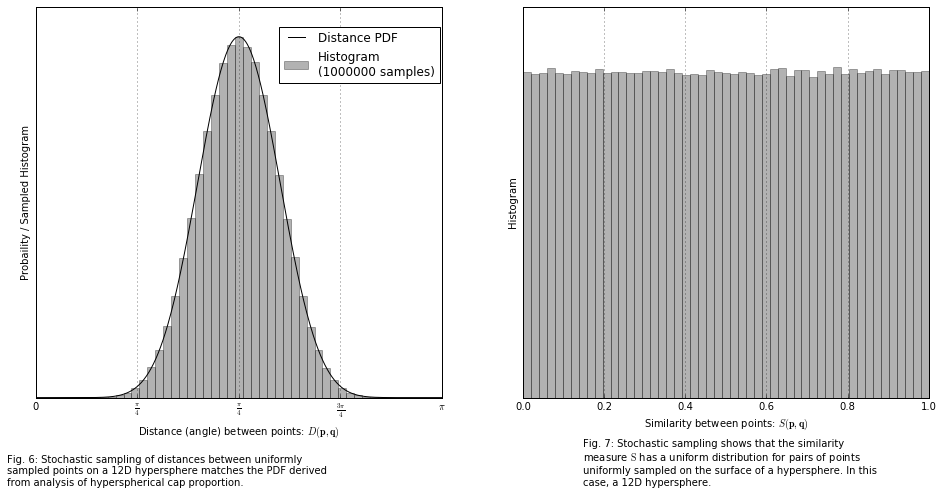

In [334]:
# Plot the PDF against the sampled histogram
fig = plt.figure(figsize=(16,7))
ax1 = fig.add_subplot(121)

ax1.plot(a, pdf12, color='k', linestyle='-', label='Distance PDF')
ax1.bar(dists[:-1],
        d_tallies / (np.pi * float(NSAMPLES / NBUCKETS)),
        color='k', alpha=0.3, width=np.pi / NBUCKETS,
        label="Histogram\n(%d samples)" % NSAMPLES)
ax1.grid()
ax1.set_xticks([0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi])
ax1.set_xticklabels(['0', '$\\frac{\\pi}{4}$','$\\frac{\\pi}{4}$','$\\frac{3\\pi}{4}$','$\\pi$'])
ax1.set_xlim((0, np.pi))
ax1.set_xlabel('Distance (angle) between points: $D(\\mathbf{p},\\mathbf{q})$')
ax1.set_yticks([])
ax1.tick_params(axis='y', which='both', left='off', labelleft='off')
ax1.set_ylabel('Probaility / Sampled Histogram')
fig.text(0.1,-0.05, 'Fig. 6: Stochastic sampling of distances between uniformly\n'
                    'sampled points on a 12D hypersphere matches the PDF derived\n'
                    'from analysis of hyperspherical cap proportion.')
plt.legend(bbox_to_anchor=(0.6, 0.95), loc=2, borderaxespad=0.0)

ax2 = fig.add_subplot(122)
ax2.bar(sims[:-1],
        s_tallies / float(NSAMPLES / NBUCKETS),
        color='k', alpha=0.3, width=1.0 / NBUCKETS,
        label="Similarity Histogram\n(%d samples)" % NSAMPLES)
plt.grid()
ax2.set_xlim((0, 1))
ax2.set_yticks([])
ax2.set_xlabel('Similarity between points: $S(\\mathbf{p},\\mathbf{q})$')
ax2.tick_params(axis='y', which='both', left='off', labelleft='off')
ax2.set_ylabel('Histogram')
fig.text(0.6,-0.05, 'Fig. 7: Stochastic sampling shows that the similarity\n'
                    'measure $\\mathrm{S}$ has a uniform distribution for pairs of points\n'
                    'uniformly sampled on the surface of a hypersphere. In this\n'
                    'case, a 12D hypersphere.')

plt.show()

### Associating Vectors

TODO

## Possible references (WIP)

* https://en.wikipedia.org/wiki/Random_indexing
* [Geva, Shlomo & De Vries, Christopher M. (2011) TOPSIG : Topology Preserving Document Signatures. In Conference on Information and Knowledge Management 2011, 24-28 October 2011, Glasgow, Scotland.](http://eprints.qut.edu.au/43451/4/43451.pdf)
* [S. Li , 2011. Concise Formulas for the Area and Volume of a Hyperspherical Cap. Asian Journal of Mathematics & Statistics, 4: 66-70.](http://scialert.net/fulltext/?doi=ajms.2011.66.70&org=11)
* Related: [Sidiropoulos, Panagiotis. "N-sphere chord length distribution." arXiv preprint arXiv:1411.5639 (2014).
APA	](https://arxiv.org/pdf/1411.5639.pdf)